<a href="https://colab.research.google.com/github/yuanyuan233333/Bayesian-statistics/blob/main/TA4_RandomNumbers_ICDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Sampling from the Uniform distribution

## Linear Congruential Generator (1958, Thomson & Rotenberg)

The Linear Congruential Generator is of of the first Pseudo-Random Number Generators (PRNGs).
It involves only very simple instructions.

Let $m$ (modulus), $\mu$ (multiplier), $c$ (increment) and $X_0$ (seed) integers.

The LCG iterates

$$
X_{i+1} = (\mu X_{i} + c) \% m
$$

Then $X_{j}$ is (approximately) distributed as a uniform over $\{1, \ldots, m\}$

$\Rightarrow$ Define $U_j := X_j / m$, $U_j \approx \text{Uniform}[0, 1]$

In [2]:
def lcg(modulus: int, a: int, c: int, seed: int):
    while True:
        seed = (a * seed + c) % modulus
        yield seed

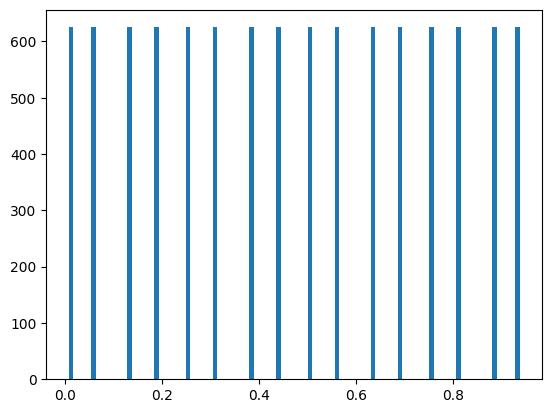

In [3]:
mod = 128
mult = 15
increment = 25
seed = 1

samples1 = []
gen = lambda x: lcg(mod, mult, increment, x)
for i in range(10000):
    seed = next(gen(seed))
    samples1.append(seed / mod)

plt.hist(samples1, bins=100)
plt.show()

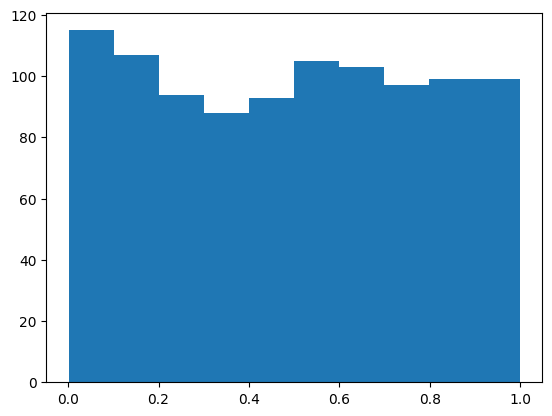

In [4]:
mod = 2 ** 31 - 1
mult = 1103515245
increment = 12345
seed = 1

samples2 = []
gen = lambda x: lcg(mod, mult, increment, x)
for i in range(1000):
    seed = next(gen(seed))
    samples2.append(seed / mod)

plt.hist(samples2, bins="scott")
plt.show()

# Compare two PRNGs using the Kolmogorov - Smirnov test

Given samples $x_1, \ldots, x_n$ let  $F_n(t) = \frac{1}{n} \sum_{i=1}^n \mathbb I[x_i < t]$ the empirical CDF.

The Kolmogorov-Smirnov test compares the emprical CDF with the expected one, i.e. tests

$$
 H_0: \lim_{n\rightarrow\infty} F_n = F_0 \qquad \text{vs. } \qquad H_1:  \lim_{n\rightarrow\infty} F_n \neq F_0
$$

Is based on the Kolmogorov-Smirnov distance

$$
 KS(F_n, F_0) = \sup_x |F_n(x) - F_0(x)|
$$

In [5]:
from scipy.stats import kstest

In [6]:
kstest(samples1, lambda x: x)

KstestResult(statistic=0.0625, pvalue=2.112988817772465e-34, statistic_location=0.0625, statistic_sign=1)

In [7]:
kstest(samples2, lambda x: x)

KstestResult(statistic=0.022699323102226165, pvalue=0.6726713518627132, statistic_location=0.25730067689777386, statistic_sign=1)

In [8]:
kstest(np.random.uniform(size=1000), lambda x: x)

KstestResult(statistic=0.02350099373925385, pvalue=0.6299217596002352, statistic_location=0.6214990062607462, statistic_sign=1)

# The Inverse CDF method

To generate a random value from $X$ we can:

1. Simulate $U \sim \text{Uniform}[0, 1]$
2. Return $F_X^{-1}(U)$

N.B. this works also for non continuous random variables!!

## Example 1 - Exponential distribution

$$ X \sim \text{Exp}(\lambda) \quad\Rightarrow\quad F_X(x) = 1 - \exp(-\lambda x) $$

In [9]:
import numpy as np

# Sampler via icdf method
def exponential_rng(lam, size=1):
    u = np.random.uniform(size=size)
    return -np.log(1.0 - u) / lam

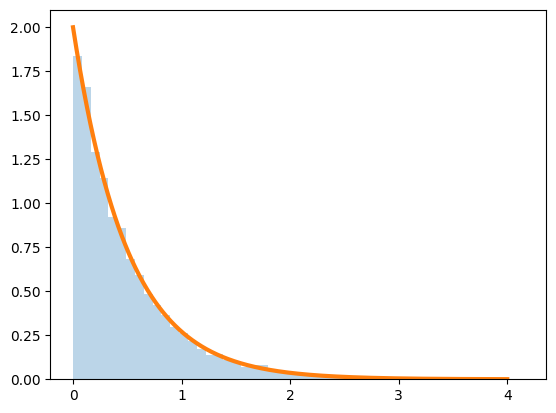

In [10]:
# Plot
plt.hist(exponential_rng(2, 10000), density=True, alpha=0.3, bins="scott")
xx = np.linspace(0, 4, 1000)
plt.plot(xx, 2 * np.exp(-2 * xx), linewidth=3)
plt.show()

Observe that

$$
1 - U \sim \text{Uniform}[0, 1]
$$

so we can speed up the code writing

In [11]:
def exponential_rng(lam, size=1):
    u = np.random.uniform(size=size)
    return -np.log(u) / lam

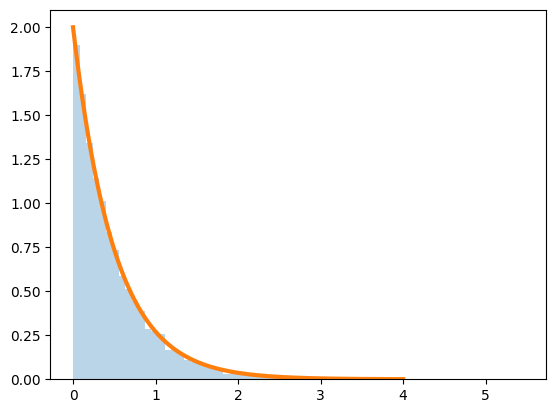

In [12]:
# Grid of points
xx = np.linspace(0, 4, 1000)

# Plot
plt.hist(exponential_rng(2, 10000), density=True, alpha=0.3, bins="scott")
plt.plot(xx, 2 * np.exp(-2 * xx), linewidth=3)
plt.show()

## Example 2 - the truncated Normal distribution

We say that $X$ follows a truncated normal distribution with parameters $\mu, \sigma^2, a, b$ if its probability density function is

$$
    f_X(x) = \frac{1}{Z(\mu, \sigma^2, a, b)}\exp\left( -\frac{(x - \mu)^2}{2 \sigma^2} \right) \mathbb I[x \in (a, b)] \propto \exp\left( -\frac{(x - \mu)^2}{2 \sigma^2} \right) \mathbb I[x \in (a, b)]
$$
<!--
We can also compute the normalizing constant:

$$
    Z(\mu, \sigma^2, a, b) = P(Y \in [a, b])
$$
where $Y \sim \mathcal{N} (\mu, \sigma^2)$

Hence
$$
    Z(\mu, \sigma^2, a, b) = \Phi\left( \frac{b - \mu}{\sigma} \right)  - \Phi\left( \frac{a - \mu}{\sigma} \right)
$$

The cumulative distribution function is then

$$
        F_X(x) =  \begin{cases}
        0 & \text{if } x < a \\
        \frac{1}{Z(\mu, \sigma^2, a, b)} \times \left( \Phi\left( \frac{x - \mu}{\sigma} \right)  - \Phi\left( \frac{a - \mu}{\sigma} \right) \right) & \text{if } a \geq x \geq b \\
        1 & \text{if } x > b
        \end{cases}
$$


The quantile function is then

$$
 u = \frac{1}{Z(\mu, \sigma^2, a, b)} \times \left( \Phi\left( \frac{x - \mu}{\sigma} \right)  - \Phi\left( \frac{a - \mu}{\sigma} \right) \right)
$$

$$
 Z(\mu, \sigma^2, a, b) u + \Phi\left( \frac{a - \mu}{\sigma} \right)  =  \Phi\left( \frac{x - \mu}{\sigma} \right)
$$

$$
 \Phi^{-1} \left( Z(\mu, \sigma^2, a, b) u + \Phi\left( \frac{a - \mu}{\sigma} \right) \right)   \sigma + \mu  =  x
$$ -->

In [13]:
from scipy.stats import norm

# Sampling via icdf method
def trunc_normal_rng(mu, sigma, a, b, size):
    u = np.random.uniform(size=size)
    z = norm.cdf((b - mu) / sigma) - norm.cdf((a - mu) / sigma)
    return norm.ppf(
        z * u + norm.cdf((a - mu) / sigma)) * sigma + mu

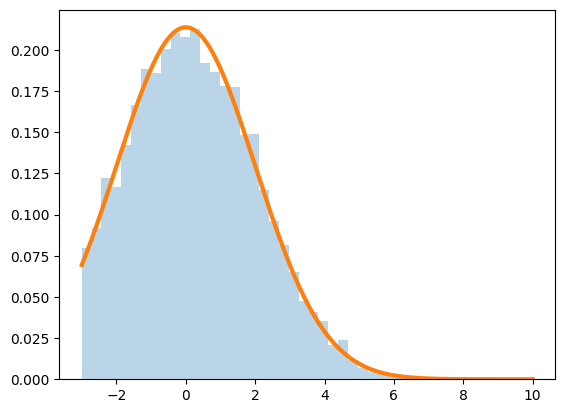

In [14]:
# Grid of points and theoretical pdf
xx = np.linspace(-3, 10, 1000)
pdf = norm.pdf(xx, loc=0, scale=2) / (norm.cdf(10 / 2) - norm.cdf(-3 / 2))

# Plot
plt.hist(trunc_normal_rng(0, 2, -3, 10, 10000), density=True, alpha=0.3, bins="scott")
plt.plot(xx, pdf, linewidth=3.0)
plt.show()